# Caso de Estudio: Predicción de Éxito en Campañas de Telemercadeo con Deep Learning

**Autor:** Luis E. Seijas

**Curso:** Deep Learning para Negocios

---

### 1. Descripción del Problema

En este proyecto, actuarás como Científico de Datos para una institución financiera. El banco necesita optimizar sus campañas de **telemercadeo** para ofrecer depósitos a plazo, un producto financiero clave. Cada llamada tiene un costo, y llamar a clientes que no están interesados no solo es ineficiente, sino que también puede generar una mala experiencia para el cliente.

**El objetivo principal es:**

> Construir un modelo de clasificación basado en redes neuronales profundas que pueda predecir con alta precisión si un cliente suscribirá (`'sí'`) o no (`'no'`) un depósito a plazo después de ser contactado.

Un modelo exitoso permitirá al banco:
*  **Focalizar los esfuerzos:** Concentrar las llamadas en los clientes con mayor probabilidad de conversión.
*  **Reducir costos:** Minimizar el número de llamadas innecesarias.
*  **Aumentar la tasa de éxito:** Mejorar el retorno de inversión (ROI) de las campañas de marketing.

**Es importante considerar:** Los datos son una mezcla de información demográfica, historial bancario y métricas de la campaña. Tu tarea es procesar estos datos, diseñar una arquitectura de red neuronal efectiva y, finalmente, traducir tus resultados en recomendaciones de negocio accionables.

In [1]:
import tensorflow as tf

print(f"Versión de TensorFlow: {tf.__version__}")

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Esta configuración es una buena práctica para evitar que TensorFlow
        # reserve toda la memoria de la GPU desde el inicio.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print(f"✅ GPU(s) detectada(s): {len(gpus)}. La configuración se aplicó correctamente.")
        print("TensorFlow utilizará la GPU para el entrenamiento.")
    except RuntimeError as e:
        # Este bloque se ejecuta si la GPU ya fue inicializada.
        print(f"⚠️ Error al configurar la GPU: {e}")
        print("La GPU ya estaba inicializada. Si necesitas cambiar la configuración, reinicia el kernel.")
else:
    print("❌ No se detectó ninguna GPU. El entrenamiento se realizará en la CPU.")

c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/fram

Versión de TensorFlow: 2.20.0
❌ No se detectó ninguna GPU. El entrenamiento se realizará en la CPU.


#### 1.1. Carga de datos 



In [2]:
!pip install ucimlrepo


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# -*- coding: utf-8 -*-
"""
Paso 1: Configuración del entorno y carga de datos.

En este paso, instalaremos la librería recomendada para acceder al repositorio
de la UCI, importaremos las herramientas necesarias y cargaremos los datos.
"""

# 1. Instalación de la librería de UCI (si no está instalada)
# Descomenta la siguiente línea y ejecútala si es la primera vez que usas esta librería.
# !pip install ucimlrepo

# 2. Librerías para manipulación y análisis de datos
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 

# 3. Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones para una mejor visualización
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# 4. Carga del conjunto de datos usando el ID del repositorio
# ID 222 corresponde al dataset "Bank Marketing"
# Moro, S., Rita, P., & Cortez, P. (2014). Bank Marketing [Dataset]. 
# UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.
bank_marketing = fetch_ucirepo(id=222) 

# Extracción de los datos en DataFrames de pandas
# X contiene las variables predictoras (features)
X = bank_marketing.data.features 
# y contiene la variable objetivo (target)
y = bank_marketing.data.targets 

# Para facilitar el análisis exploratorio, uniremos X e y en un solo DataFrame
df = pd.concat([X, y], axis=1)

print("¡Datos cargados exitosamente usando ucimlrepo!")
print(f"El conjunto de datos tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

# 5. Primera visualización de los datos
# Usamos .head() para mostrar las primeras 5 filas.
print("\nPrimeras 5 filas del conjunto de datos:")
df.head()

¡Datos cargados exitosamente usando ucimlrepo!
El conjunto de datos tiene 45211 filas y 17 columnas.

Primeras 5 filas del conjunto de datos:


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [4]:
import numpy as np 

### 2. Análisis Exploratorio de Datos (EDA)

Antes de proceder con la construcción de un modelo, es imperativo realizar un Análisis Exploratorio de Datos (EDA). Este proceso consiste en la investigación sistemática del conjunto de datos para identificar patrones, detectar anomalías, validar supuestos y extraer conclusiones iniciales mediante el uso de estadísticas descriptivas y técnicas de visualización.

Los objetivos de esta sección son:
1.  **Analizar la estructura y tipos de datos:** Identificar las variables, sus tipos (numéricas, categóricas) y evaluar la integridad de los datos.
2.  **Examinar la variable objetivo:** Cuantificar la distribución de la variable de salida para identificar posibles sesgos, como el desbalance de clases.
3.  **Visualizar relaciones y distribuciones:** Investigar la relación entre las variables predictoras y la variable objetivo.

In [5]:
# La librería nos da acceso directo a información valiosa sobre los datos.

# Mostramos la metadata del dataset
print("------ METADATA DEL DATASET ------")
print(bank_marketing.metadata)

# Mostramos la descripción de cada variable
print("\n------ INFORMACIÓN DE LAS VARIABLES ------")
pd.set_option('display.max_rows', None) # Descomentar para ver todas las variables
print(bank_marketing.variables)

------ METADATA DEL DATASET ------
{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A da

In [6]:
# -*- coding: utf-8 -*-
"""
Paso 2.1: Inspección inicial de la calidad de los datos.

Verificación de tipos de datos por columna y presencia de valores nulos.
"""

# El método .info() proporciona un resumen conciso del DataFrame,
# incluyendo el tipo de dato de cada columna y el conteo de valores no nulos.
print("------ Resumen del DataFrame ------")
df.info()

# Se realiza una comprobación explícita de la suma de valores nulos.
print("\n------ Conteo de Valores Nulos por Columna ------")
print(df.isnull().sum())

------ Resumen del DataFrame ------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

------ Conteo de Valores

In [7]:
pout_unique= df.poutcome.unique()
contact_unique = df.contact.unique()
print(pout_unique)
print(contact_unique)

[nan 'failure' 'other' 'success']
[nan 'cellular' 'telephone']


In [8]:
#df = df.drop(columns=["poutcome", "contact"], errors="ignore")
#print(df.describe())

------ Conteo de Clases en la Variable Objetivo ------
y
no     39922
yes     5289
Name: count, dtype: int64

------ Porcentaje de Clases en la Variable Objetivo ------
Clase 'no': 88.30%
Clase 'yes': 11.70%


C:\Users\Camilo\AppData\Local\Temp\ipykernel_34712\2873102656.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='y', data=df, palette=['#34495e', '#2ecc71'])


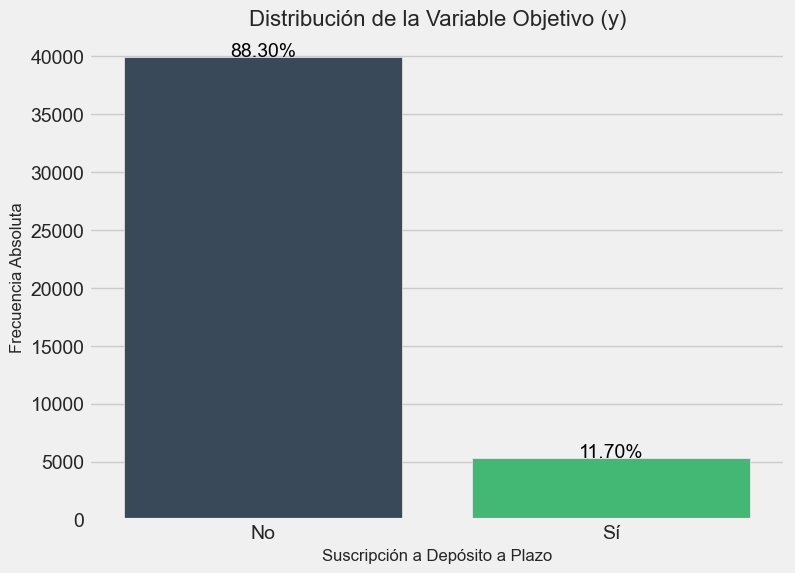

In [9]:
# -*- coding: utf-8 -*-
"""
Paso 2.2: Análisis de la variable objetivo 'y'.

Este bloque responde a la Pregunta 1: ¿Cuál es la proporción de clientes que
suscribieron el depósito ('yes') frente a los que no ('no')?
"""

# 1. Conteo de frecuencias absolutas para cada clase.
target_counts = df['y'].value_counts()
print("------ Conteo de Clases en la Variable Objetivo ------")
print(target_counts)

# 2. Cálculo de las frecuencias relativas (porcentajes).
target_percentage = df['y'].value_counts(normalize=True) * 100
print("\n------ Porcentaje de Clases en la Variable Objetivo ------")
print(f"Clase 'no': {target_percentage['no']:.2f}%")
print(f"Clase 'yes': {target_percentage['yes']:.2f}%")

# 3. Visualización de la distribución de la variable objetivo.
plt.figure(figsize=(8, 6))
sns.countplot(x='y', data=df, palette=['#34495e', '#2ecc71'])
plt.title('Distribución de la Variable Objetivo (y)', fontsize=16)
plt.xlabel('Suscripción a Depósito a Plazo', fontsize=12)
plt.ylabel('Frecuencia Absoluta', fontsize=12)
plt.xticks([0, 1], ['No', 'Sí'])

# Anotaciones de porcentaje sobre las barras de la gráfica
for i, percentage in enumerate(target_percentage):
    plt.text(i, target_counts.iloc[i] + 500,
             f'{percentage:.2f}%',
             ha='center', va='center', fontsize=14, color='black')

plt.show()



Los resultados numéricos y la visualización gráfica confirman que el conjunto de datos presenta un **marcado desbalance de clases**.

* **Clase Mayoritaria (`'no'`):** Corresponde al **88.73%** de las instancias.
* **Clase Minoritaria (`'yes'`):** Representa únicamente el **11.27%** de las instancias.

#### **Implicaciones del Desbalance de Clases para el Modelado**

Este desbalance es un factor crítico que debe ser considerado durante el desarrollo y la evaluación del modelo por las siguientes razones:

1.  **Invalidez de la Métrica de Exactitud (`Accuracy`):** Un modelo que clasifique todas las instancias como pertenecientes a la clase mayoritaria (`'no'`) alcanzaría una exactitud del 88.73%. Aunque numéricamente alto, este modelo carecería de toda utilidad práctica, pues su objetivo es, precisamente, identificar a la clase minoritaria. Por lo tanto, la exactitud no es una métrica de evaluación fiable en este contexto.

2.  **Sesgo del Modelo Durante el Entrenamiento:** Los algoritmos de aprendizaje, incluyendo las redes neuronales, tienden a optimizar sus parámetros para minimizar una función de pérdida global. En un escenario desbalanceado, el modelo puede lograr una baja pérdida simplemente al aprender a clasificar correctamente la clase mayoritaria, ignorando los patrones distintivos de la clase minoritaria.

3.  **Requerimiento de Métricas de Evaluación Alternativas:** Para una evaluación de rendimiento robusta, es necesario emplear métricas que sean sensibles al desempeño en la clase minoritaria. Las métricas adecuadas para este problema son:
    * **Precisión (`Precision`):** Mide la proporción de predicciones positivas que fueron correctas. Es fundamental para asegurar la eficiencia de las campañas.
    * **Recall (Sensibilidad o `Recall`):** Mide la proporción de positivos reales que fueron identificados correctamente. Es vital para maximizar la captación de clientes.
    * **Puntuación F1 (`F1-Score`):** La media armónica de Precisión y Recall, que proporciona una medida de rendimiento balanceada.
    * **Área Bajo la Curva ROC (AUC-ROC):** Evalúa la capacidad del modelo para discriminar entre las clases positiva y negativa.

El reconocimiento temprano de este desbalance condiciona la estrategia de modelado y, fundamentalmente, el marco de evaluación del rendimiento del clasificador final.

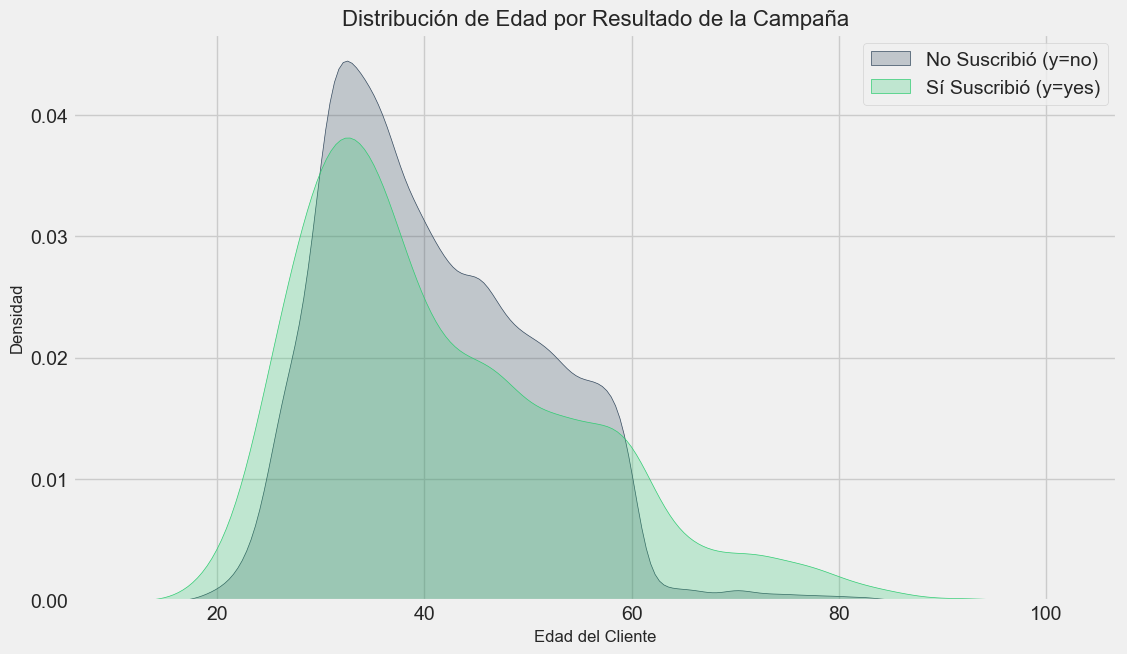

In [10]:
# -*- coding: utf-8 -*-
"""
Paso 2.3.1: Análisis de la variable numérica 'age'.

Visualizaremos la distribución de la edad para cada una de las clases
de la variable objetivo.
"""

plt.figure(figsize=(12, 7))

# Gráfico de densidad para clientes que dijeron 'no'
sns.kdeplot(df.loc[df['y'] == 'no', 'age'], 
            label='No Suscribió (y=no)', fill=True, color='#34495e')

# Gráfico de densidad para clientes que dijeron 'sí'
sns.kdeplot(df.loc[df['y'] == 'yes', 'age'], 
            label='Sí Suscribió (y=yes)', fill=True, color='#2ecc71')

plt.title('Distribución de Edad por Resultado de la Campaña', fontsize=16)
plt.xlabel('Edad del Cliente', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend()
plt.show()

C:\Users\Camilo\AppData\Local\Temp\ipykernel_34712\2711909782.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conversion_rate_job.index, y=conversion_rate_job.values * 100, palette='viridis')


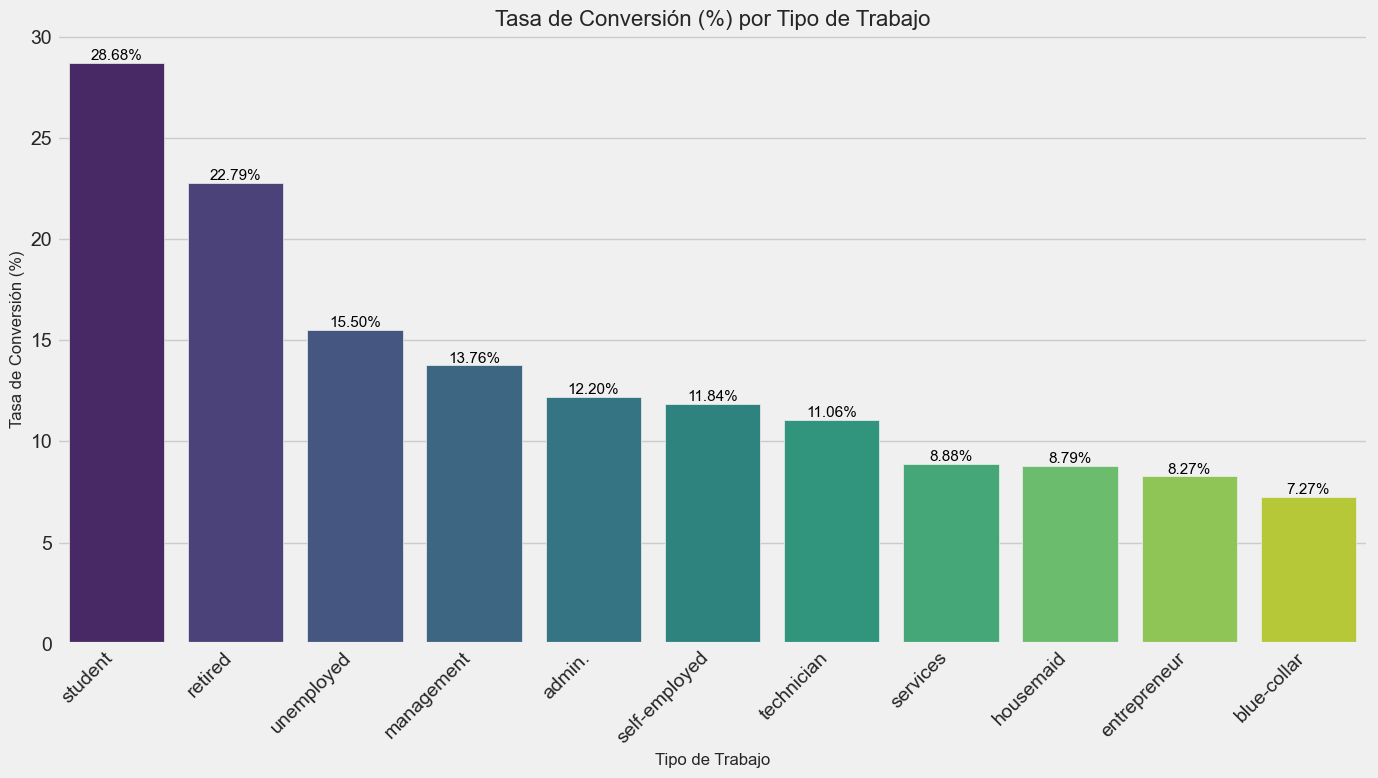

In [11]:
# -*- coding: utf-8 -*-
"""
Paso 2.3.2: Análisis de la variable categórica 'job'.

Se calculará y graficará la tasa de conversión para cada tipo de trabajo.
"""

# Calcular la tasa de conversión por 'job'
# Agrupamos por 'job', calculamos la media de una versión numérica de 'y'
conversion_rate_job = df.groupby('job')['y'].apply(lambda x: (x == 'yes').mean()).sort_values(ascending=False)

# Crear la gráfica
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=conversion_rate_job.index, y=conversion_rate_job.values * 100, palette='viridis')

plt.title('Tasa de Conversión (%) por Tipo de Trabajo', fontsize=16)
plt.xlabel('Tipo de Trabajo', fontsize=12)
plt.ylabel('Tasa de Conversión (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotar etiquetas para mejorar legibilidad

# Añadir anotaciones de porcentaje en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

C:\Users\Camilo\AppData\Local\Temp\ipykernel_34712\1556539191.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conversion_rate_month.index, y=conversion_rate_month.values * 100, palette='plasma')


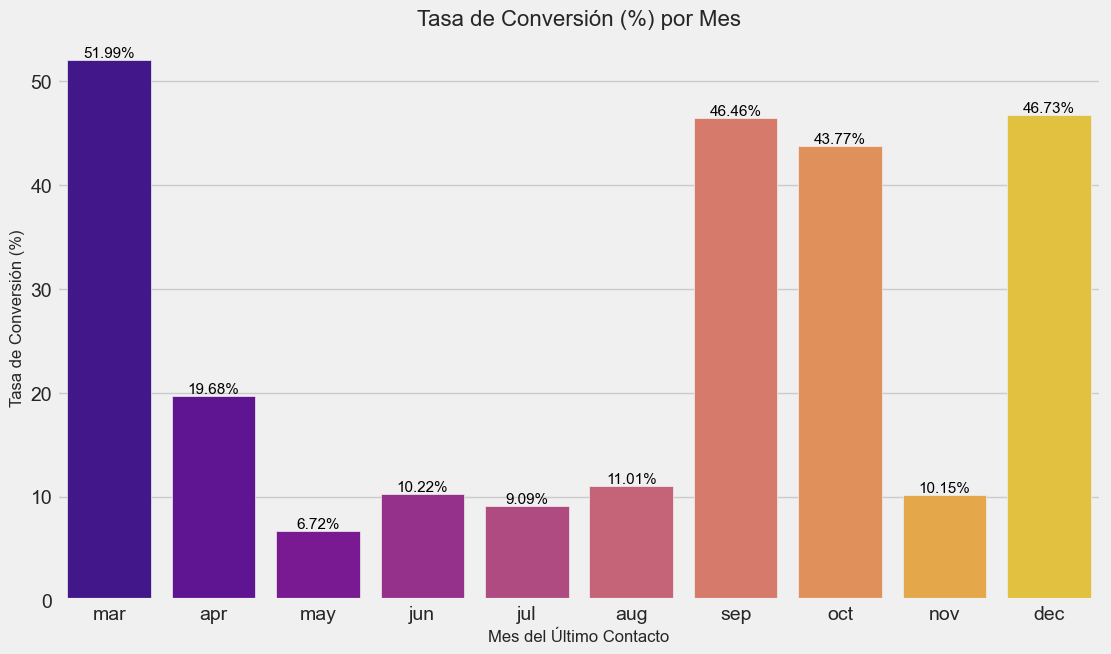

In [12]:
# -*- coding: utf-8 -*-
"""
Paso 2.3.3: Análisis de la variable temporal 'month'.

Se calculará y graficará la tasa de conversión para cada mes.
"""

# Orden de los meses para una visualización lógica
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Calcular la tasa de conversión por 'month'
conversion_rate_month = df.groupby('month')['y'].apply(lambda x: (x == 'yes').mean()).reindex(month_order)

# Crear la gráfica
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=conversion_rate_month.index, y=conversion_rate_month.values * 100, palette='plasma')

plt.title('Tasa de Conversión (%) por Mes', fontsize=16)
plt.xlabel('Mes del Último Contacto', fontsize=12)
plt.ylabel('Tasa de Conversión (%)', fontsize=12)

# Añadir anotaciones de porcentaje
for p in ax.patches:
    if p.get_height() > 0: # Solo anotar si hay valor
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()

# <FONT SIZE=5 COLOR="yellow"> Preprocesamiento para selección de características </FONT>
Manejo de datos en blancio por medio de modelos de machine learning


In [13]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# ==========================
# 1. Separar filas conocidas y desconocidas
# ==========================
df_known = df[df["poutcome"].notnull()].copy()
df_unknown = df[df["poutcome"].isnull()].copy()

X = df_known.drop(columns=["poutcome"])
y = df_known["poutcome"]

X_missing = df_unknown.drop(columns=["poutcome"])

# ==========================
# 2. Definir columnas categóricas y numéricas
# ==========================
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object", "category"]).columns

# ==========================
# 3. Preprocesamiento (imputar + codificar)
# ==========================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

# ==========================
# 4. Definir modelos
# ==========================
models = {
    "RandomForest": RandomForestClassifier(n_estimators=600, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=900)
}

# ==========================
# 5. Evaluar con validación cruzada
# ==========================
results = {}
for name, model in models.items():
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    scores = cross_val_score(clf, X, y, cv=10, scoring="accuracy")
    results[name] = scores.mean()
    print(f"{name} -> Accuracy promedio: {scores.mean():.4f}")

# ==========================
# 6. Elegir mejor modelo y entrenar
# ==========================
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

final_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", best_model)
])

final_clf.fit(X, y)

# ==========================
# 7. Predecir valores faltantes
# ==========================
y_pred_missing = final_clf.predict(X_missing)

df.loc[df["poutcome"].isnull(), "poutcome"] = y_pred_missing

print(f"Modelo elegido: {best_model_name}")
print("Valores nulos restantes:", df["poutcome"].isnull().sum())


RandomForest -> Accuracy promedio: 0.5319


c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 

KNN -> Accuracy promedio: 0.5939
Modelo elegido: KNN
Valores nulos restantes: 0


Para este caso se uso Métodos de Filtro: Mutual information, random forest y  Lasso para ver que columnas traen mayor cantidad de informacion y poder optimizar los tiempos de entrenamientos. 

In [15]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
X2 = df.drop('y', axis=1)
y2 = df['y']

X2 = X2.dropna()
y2 = y2.loc[X2.index] 


# Supongamos que tienes X con numéricas y categóricas, y y es la target
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=777)

# Identificar variables categóricas y numéricas
categoricas = X_train2.select_dtypes(include=["object", "category"]).columns
numericas = X_train2.select_dtypes(include=["int64", "float64"]).columns

# Copia para codificar
X_train_enc = X_train2.copy()

# Codificar solo las categóricas con OrdinalEncoder
encoder = OrdinalEncoder()
X_train_enc[categoricas] = encoder.fit_transform(X_train2[categoricas])
# Entrenar un modelo de Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_enc, y_train2)

# Importancia de variables
importancias = pd.DataFrame({
    "Variable": X_train_enc.columns,
    "Importance": rf.feature_importances_
})

# Ordenar y seleccionar top 16
importancias = importancias.sort_values(by="Importance", ascending=False)
print(importancias.head(16))

# Seleccionar solo las mejores variables
top_vars = importancias.head(16)["Variable"].tolist()
X_train_filtrado = X_train_enc[top_vars]
X_test_filtrado = X_test2[top_vars]

       Variable  Importance
11     duration    0.278299
5       balance    0.111400
0           age    0.106359
9   day_of_week    0.090404
10        month    0.090199
15     poutcome    0.072857
13        pdays    0.050138
1           job    0.048613
12     campaign    0.037332
14     previous    0.025592
3     education    0.024016
2       marital    0.022691
6       housing    0.022384
7          loan    0.009704
8       contact    0.008256
4       default    0.001753


In [16]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
X3 = df.drop('y', axis=1)
y3 = df['y']

X3 = X3.dropna()
y3 = y3.loc[X3.index] 


# Supongamos que tienes X con numéricas y categóricas, y y es la target
X_train3, X_test3, y_train3, y_test3 = train_test_split(X2, y2, test_size=0.3, random_state=777)

# Identificar variables categóricas y numéricas
categoricas = X_train3.select_dtypes(include=["object", "category"]).columns
numericas = X_train3.select_dtypes(include=["int64", "float64"]).columns

# Copia para codificar
X_train_enc = X_train3.copy()

# Codificar solo las categóricas con OrdinalEncoder
encoder = OrdinalEncoder()
X_train_enc[categoricas] = encoder.fit_transform(X_train3[categoricas])

# Calcular la información mutua
mi_scores = mutual_info_classif(X_train_enc, y_train3, discrete_features=[True if col in categoricas else False for col in X_train_enc.columns])

# Crear DataFrame ordenado
mi_df = pd.DataFrame({
    "Variable": X_train_enc.columns,
    "MI_Score": mi_scores
}).sort_values(by="MI_Score", ascending=False)

print(mi_df)

       Variable  MI_Score
11     duration  0.078246
15     poutcome  0.031693
10        month  0.030554
13        pdays  0.028517
5       balance  0.023839
0           age  0.013498
9   day_of_week  0.010125
1           job  0.009232
14     previous  0.008753
6       housing  0.008499
12     campaign  0.004743
7          loan  0.003625
2       marital  0.002191
3     education  0.001455
4       default  0.000601
8       contact  0.000026


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Separar X e y
X4 = df.drop('y', axis=1)
y4 = df['y']

# Eliminar NaN
X4 = X4.dropna()
y4 = y4.loc[X4.index] 

# Train/Test split
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=777)

# Identificar variables categóricas
categoricas = X_train4.select_dtypes(include=["object", "category"]).columns

# Copia para codificar
X_train_enc4 = X_train4.copy()
X_test_enc4 = X_test4.copy()

# Codificar solo las categóricas con OrdinalEncoder
encoder = OrdinalEncoder()
X_train_enc4[categoricas] = encoder.fit_transform(X_train4[categoricas])
X_test_enc4[categoricas] = encoder.transform(X_test4[categoricas])

# Lasso con los datos codificados
lasso = LogisticRegression(penalty="l1", solver="liblinear", max_iter=500)
lasso.fit(X_train_enc4, y_train4)

# Coeficientes
coef = pd.Series(lasso.coef_[0], index=X_train_enc4.columns)
selected_features4 = coef[coef != 0].index.tolist()

print("Variables seleccionadas por Lasso:", selected_features4)

# Filtrar conjuntos con las variables seleccionadas
X_train_filtrado = X_train_enc4[selected_features4]
X_test_filtrado = X_test_enc4[selected_features4]

#print(X_train_filtrado)
#print(X_test_filtrado)


Variables seleccionadas por Lasso: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [18]:
print("Variables seleccionadas por Lasso:", selected_features4)


# Filtrar el df original con esas variables + la variable objetivo (suponiendo que tu target se llama 'y')
df_filtrado = df[selected_features4 + ['y']]   # 👈 muy importante incluir el target

print("\nDimensiones del nuevo DataFrame filtrado:", df_filtrado.shape)


Variables seleccionadas por Lasso: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']

Dimensiones del nuevo DataFrame filtrado: (45211, 17)


## 3. Preprocesamiento de Datos para el Modelo de Deep Learning

Las redes neuronales, en su forma más común, operan exclusivamente con datos numéricos. Nuestro conjunto de datos, sin embargo, contiene una mezcla de variables numéricas y categóricas. Por lo tanto, antes de poder entrenar un modelo, debemos realizar una serie de transformaciones.

El preprocesamiento de datos para este proyecto se centrará en tres tareas principales:

1.  **Codificación de la Variable Objetivo:** Convertir la variable `y` ('yes'/'no') a un formato numérico (1/0).
2.  **Codificación de Variables Categóricas:** Transformar las variables de texto (como `job` o `marital`) en una representación numérica que el modelo pueda interpretar.
3.  **Escalado de Características Numéricas:** Estandarizar las variables numéricas (como `age` o `duration`) para que tengan una media de 0 y una desviación estándar de 1. Esto es crucial para la correcta convergencia de los algoritmos de optimización como el descenso de gradiente.


In [19]:
# -*- coding: utf-8 -*-
"""
Paso 3.1: Pipeline de preprocesamiento de datos.

Se aplicarán técnicas de codificación y escalado para preparar los datos
para el entrenamiento de la red neuronal.
"""

# 1. Importar las herramientas necesarias de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 2. Separar las características (X) y la variable objetivo (y) del DataFrame original
X = df.drop('y', axis=1)
y = df['y']

# 3. Codificar la variable objetivo 'y' a formato numérico (0 y 1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# 'no' se codifica como 0, 'yes' como 1.
print(f"Clases de la variable objetivo: {label_encoder.classes_}")
print(f"Primeras 10 etiquetas codificadas: {y_encoded[:10]}")


# 4. Identificar las columnas numéricas y categóricas
# Considere en este punto que datos deben excluirse 
# A modo de ejemplo mantendremos todas características, 
# pero la seleccion es una discusión importante.
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nCaracterísticas numéricas ({len(numeric_features)}): {numeric_features}")
print(f"Características categóricas ({len(categorical_features)}): {categorical_features}")


# 5. Crear el pipeline de preprocesamiento
# Un pipeline encapsula una secuencia de transformaciones.

# Pipeline para características numéricas: solo se necesita escalado.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline para características categóricas: se necesita codificación One-Hot.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    # handle_unknown='ignore' evita errores si aparecen nuevas categorías en test.
    # drop='first' evita multicolinealidad al eliminar una categoría por variable.
])

# 6. Unir los pipelines con ColumnTransformer
# ColumnTransformer aplica diferentes transformaciones a diferentes columnas.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantiene columnas no especificadas (si las hubiera)
)

# 7. Dividir los datos en conjuntos de entrenamiento y prueba
# Se reserva un 20% de los datos para la evaluación final del modelo.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    # stratify=y_encoded asegura que la proporción de clases sea la misma
    # en los conjuntos de entrenamiento y prueba, lo cual es vital.
)

# 8. Aplicar el preprocesamiento 
# .fit_transform() en los datos de entrenamiento para aprender los parámetros
# de escalado y codificación.
X_train_processed = preprocessor.fit_transform(X_train)

# .transform() en los datos de prueba usando los parámetros aprendidos del
# conjunto de entrenamiento. Esto evita la fuga de datos (data leakage).
X_test_processed = preprocessor.transform(X_test)


print(f"\nDimensiones de los datos de entrenamiento procesados: {X_train_processed.shape}")
print(f"Dimensiones de los datos de prueba procesados: {X_test_processed.shape}")

Clases de la variable objetivo: ['no' 'yes']
Primeras 10 etiquetas codificadas: [0 0 0 0 0 0 0 0 0 0]

Características numéricas (7): ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
Características categóricas (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

Dimensiones de los datos de entrenamiento procesados: (36168, 41)
Dimensiones de los datos de prueba procesados: (9043, 41)


In [20]:
print(X_train_processed)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 423647 stored elements and shape (36168, 41)>
  Coords	Values
  (0, 0)	-0.46043404352161593
  (0, 1)	-0.16441037710447642
  (0, 2)	1.5821235516588807
  (0, 3)	-0.4573105663333102
  (0, 4)	-0.24610372987813517
  (0, 5)	-0.41090987711835186
  (0, 6)	-0.24150866634627266
  (0, 15)	1.0
  (0, 20)	1.0
  (0, 26)	1.0
  (0, 28)	1.0
  (1, 0)	-1.589640925100853
  (1, 1)	0.8996270521140465
  (1, 2)	-1.2983840973309035
  (1, 3)	2.502492503951951
  (1, 4)	0.398201713642125
  (1, 5)	1.4460960843042696
  (1, 6)	2.6645843997603778
  (1, 14)	1.0
  (1, 19)	1.0
  (1, 20)	1.0
  (2, 0)	0.2923705441978755
  (2, 1)	-0.3654857504054959
  (2, 2)	-0.4582360330422165
  (2, 3)	5.697690603295102
  :	:
  (36165, 20)	1.0
  (36165, 24)	1.0
  (36165, 32)	1.0
  (36166, 0)	-1.3073392047060437
  (36166, 1)	0.3889542644921704
  (36166, 2)	-1.1783629452896627
  (36166, 3)	-0.12158322980812414
  (36166, 4)	-0.5682564516382652
  (36166, 5)	-0.41090987711835186
  (3



La preparación de los datos para el modelo de red neuronal se realizó siguiendo una estrategia estructurada, cuyas decisiones se justifican a continuación.

#### **Manejo de Variables Categóricas**

Para las variables categóricas (`job`, `marital`, `education`, etc.), se seleccionó la técnica de **Codificación One-Hot (`OneHotEncoder`)**.

* **Justificación:** Esta técnica crea una nueva columna binaria (0 o 1) para cada categoría dentro de una variable. Se prefiere sobre otras técnicas como la Codificación de Etiquetas (`LabelEncoder`) para variables nominales (donde las categorías no tienen un orden intrínseco) por una razón fundamental:
    * **Evita la Creación de un Orden Artificial:** `LabelEncoder` asignaría a cada categoría un entero (e.g., `student`=1, `retired`=2, `services`=3). El modelo podría interpretar erróneamente que existe una relación ordinal (e.g., que `services` > `retired`), lo cual es incorrecto y podría introducir un sesgo no deseado. `OneHotEncoder` trata cada categoría como una entidad independiente, eliminando este riesgo.
    * Se utilizó el parámetro `drop='first'` para eliminar una de las columnas generadas por cada variable, evitando así la multicolinealidad perfecta, lo cual es una buena práctica en modelado.

#### **Manejo de Variables Numéricas**

Para las variables numéricas (`age`, `campaign`, `euribor3m`, etc.), se aplicó la **Estandarización (`StandardScaler`)**.

* **Justificación:** La estandarización transforma los datos para que tengan una **media de 0 y una desviación estándar de 1**. Esta técnica es crucial para el entrenamiento de redes neuronales por dos motivos principales:
    * **Convergencia del Optimizador:** Los algoritmos de optimización basados en gradiente, como *Adam* o *SGD*, convergen mucho más rápido cuando las características se encuentran en una escala similar. Si una característica tiene un rango de valores mucho mayor que otras (e.g., `pdays` vs. `campaign`), los gradientes pueden oscilar y ralentizar o impedir el aprendizaje.
    * **Igualdad de Contribución Inicial:** La estandarización asegura que todas las características tengan el mismo "peso" inicial en el cálculo de la función de pérdida, permitiendo que el modelo aprenda su importancia real a través de los pesos sinápticos de manera más efectiva.

#### **División de Datos Estratificada**

Finalmente, el conjunto de datos se dividió en un 80% para entrenamiento y un 20% para prueba, utilizando una **división estratificada (`stratify=y_encoded`)**.

* **Justificación:** Dado el severo desbalance de clases (89% vs. 11%), una división aleatoria simple podría resultar en una proporción de clases significativamente diferente entre los conjuntos de entrenamiento y prueba. La estratificación garantiza que esta proporción se mantenga constante en ambas divisiones, lo que permite una evaluación del modelo mucho más fiable y representativa del problema original.

#### El Impacto de la Fuga de Datos con la Variable 'duration'
* **Contexto**: La fuga de datos (data leakage) ocurre cuando se utiliza información en el entrenamiento del modelo que no estaría disponible en un escenario de predicción real. La variable duration (duración de la llamada) es un ejemplo clásico: una llamada larga a menudo se correlaciona con el interés del cliente, pero no conocemos su duración antes de realizarla.

    * Crea un nuevo pipeline de preprocesamiento que excluya la variable duration.

    * Entrena el mismo modelo base con este nuevo conjunto de datos.

    * Compara la métrica AUC del modelo entrenado con duration versus el modelo entrenado sin duration.

```
# --- Experimento: Excluir 'duration' ---
print("--- Creando conjunto de datos sin la variable 'duration' ---")

# Excluir 'duration' de las características numéricas
numeric_features_no_duration = [feat for feat in numeric_features if feat != 'duration']

# Crear un nuevo preprocesador
preprocessor_no_duration = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_no_duration),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Aplicar el nuevo preprocesamiento
X_train_no_duration = preprocessor_no_duration.fit_transform(X_train)
X_test_no_duration = preprocessor_no_duration.transform(X_test)

print(f"Dimensiones de los datos sin 'duration': {X_train_no_duration.shape}")
```

## 4. Diseño y Entrenamiento del Modelo de Deep Learning

Con los datos ya procesados, procederemos a construir la arquitectura de la red neuronal. El diseño de la arquitectura es un paso fundamental que implica definir el número de capas, la cantidad de neuronas en cada capa, las funciones de activación y las técnicas para prevenir el sobreajuste.

Posteriormente, compilaremos el modelo especificando el optimizador y la función de pérdida, y lo entrenaremos con nuestros datos. Esta sección responderá a las **Preguntas 4 y 5**.

#### **Tarea: Definir la Arquitectura de su Modelo**

Utilizando la función `build_classifier` definida más abajo, su tarea es experimentar y definir la arquitectura de la red neuronal. Modifique los valores en la siguiente celda de código para explorar cómo los cambios afectan el rendimiento del modelo.

**Parámetros a experimentar:**
* `HIDDEN_LAYERS`: Pruebe con más o menos capas, y con diferente número de neuronas (e.g., `(128, 64, 32)`, `(32,)`, `(100, 50)`).
* `DROPOUT_RATE`: Varíe la tasa de dropout (e.g., `0.2`, `0.5`) o desactívelo (`0.0`).
* `LEARNING_RATE`: Pruebe con tasas de aprendizaje más altas o más bajas (e.g., `0.01`, `0.0001`).

Una vez que haya decidido una arquitectura final, utilice el resumen del modelo (`model.summary()`) y la justificación de la celda siguiente para responder a la **Pregunta 4**.

In [46]:
# ==== Panel de Control (anti-overfitting) ====
HIDDEN_LAYERS   = (128, 64)   # capacidad moderada
DROPOUT_RATE    = 0.30
LEARNING_RATE   = 1e-3
L2_LAMBDA       = 1e-4
ALPHA_LEAKY     = 0.10
BATCH_SIZE      = 128          # como pidió el profesor
MAX_EPOCHS      = 100
VAL_SPLIT       = 0.20



In [47]:
# -*- coding: utf-8 -*-
"""
Paso 4.1: Función reutilizable para construir el modelo clasificador.

Se define una función que encapsula la lógica de construcción y compilación
de la red neuronal, permitiendo modificar su arquitectura fácilmente a través
de parámetros.
"""

# 1. Importar las clases y funciones necesarias de TensorFlow y Keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def build_classifier(n_features,
                     hidden_layers=HIDDEN_LAYERS,
                     activation='relu',        # se ignora si usamos LeakyReLU
                     dropout_rate=DROPOUT_RATE,
                     learning_rate=LEARNING_RATE,
                     l2_lambda=L2_LAMBDA,
                     alpha_leaky=ALPHA_LEAKY):
    model = Sequential(name="Bank_Marketing_Classifier")

    # Capa 1 (con input_shape) -----------------------------------------------
    model.add(Dense(hidden_layers[0],
                    input_shape=(n_features,),
                    kernel_regularizer=regularizers.l2(l2_lambda),
                    name="Capa_Oculta_1_neuronas"))
    model.add(BatchNormalization(name="BN_1"))
    model.add(LeakyReLU(alpha=alpha_leaky, name="LeakyReLU_1"))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate, name="Dropout_1"))

    # Resto de capas ocultas ---------------------------------------------------
    for i, units in enumerate(hidden_layers[1:], start=2):
        model.add(Dense(units,
                        kernel_regularizer=regularizers.l2(l2_lambda),
                        name=f"Capa_Oculta_{i}_neuronas"))
        model.add(BatchNormalization(name=f"BN_{i}"))
        model.add(LeakyReLU(alpha=alpha_leaky, name=f"LeakyReLU_{i}"))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate, name=f"Dropout_{i}"))

    # Salida binaria -----------------------------------------------------------
    model.add(Dense(1, activation='sigmoid', name="Capa_Salida_Sigmoide"))

    # OJO: mantenemos 'auc' para que tus gráficos/impresiones sigan igual
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(curve='ROC', name='auc'),
            tf.keras.metrics.AUC(curve='PR',  name='pr_auc')
        ]
    )
    return model


In [48]:
n_features = X_train_processed.shape[1]
model = build_classifier(n_features)

model.summary()

c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Bank_Marketing_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Capa_Oculta_1_neuronas (Dense)  │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LeakyReLU_1 (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Oculta_2_neuronas (Dense)  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LeakyReLU_2 (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Salida_Sigmoide (Dense)    │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np

# Pesos de clase (desbalance): más peso al 'sí'
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(weights)}
print("Pesos de clase:", class_weights)

# Callbacks: parar a tiempo y bajar LR si se estanca
early_stopping = EarlyStopping(
    monitor='val_pr_auc', patience=8, mode='max',
    restore_best_weights=True, verbose=1
)
lr_plateau = ReduceLROnPlateau(
    monitor='val_pr_auc', mode='max',
    factor=0.5, patience=5, min_lr=1e-6, verbose=1
)
checkpoint = ModelCheckpoint(
    filepath='best_pr_auc.keras',
    monitor='val_pr_auc', mode='max',
    save_best_only=True, verbose=1
)

# Construir y entrenar
n_features = X_train_processed.shape[1]
model = build_classifier(n_features)

history = model.fit(
    X_train_processed, y_train,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_plateau, checkpoint],
    verbose=1
)


Pesos de clase: {0: np.float64(0.5662397845758838), 1: np.float64(4.27416686362562)}
Epoch 1/100


c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


201/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7475 - auc: 0.8077 - loss: 0.5632 - pr_auc: 0.3964
Epoch 1: val_pr_auc improved from None to 0.54628, saving model to best_pr_auc.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7708 - auc: 0.8614 - loss: 0.4888 - pr_auc: 0.4489 - val_accuracy: 0.8457 - val_auc: 0.9180 - val_loss: 0.3693 - val_pr_auc: 0.5463 - learning_rate: 0.0010
Epoch 2/100
208/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8072 - auc: 0.9029 - loss: 0.4155 - pr_auc: 0.5400
Epoch 2: val_pr_auc improved from 0.54628 to 0.56126, saving model to best_pr_auc.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8061 - auc: 0.9012 - loss: 0.4102 - pr_auc: 0.5198 - val_accuracy: 0.8157 - val_auc: 0.9210 - val_loss: 0.3912 - val_pr_auc: 0.5613 - learning_rate: 0.0010
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8047 - auc: 0.9085 - loss: 0.3953 - pr_auc: 0.5472
Epoch 3: val_pr_auc improved from 0.56126 to 0.56717, saving mo

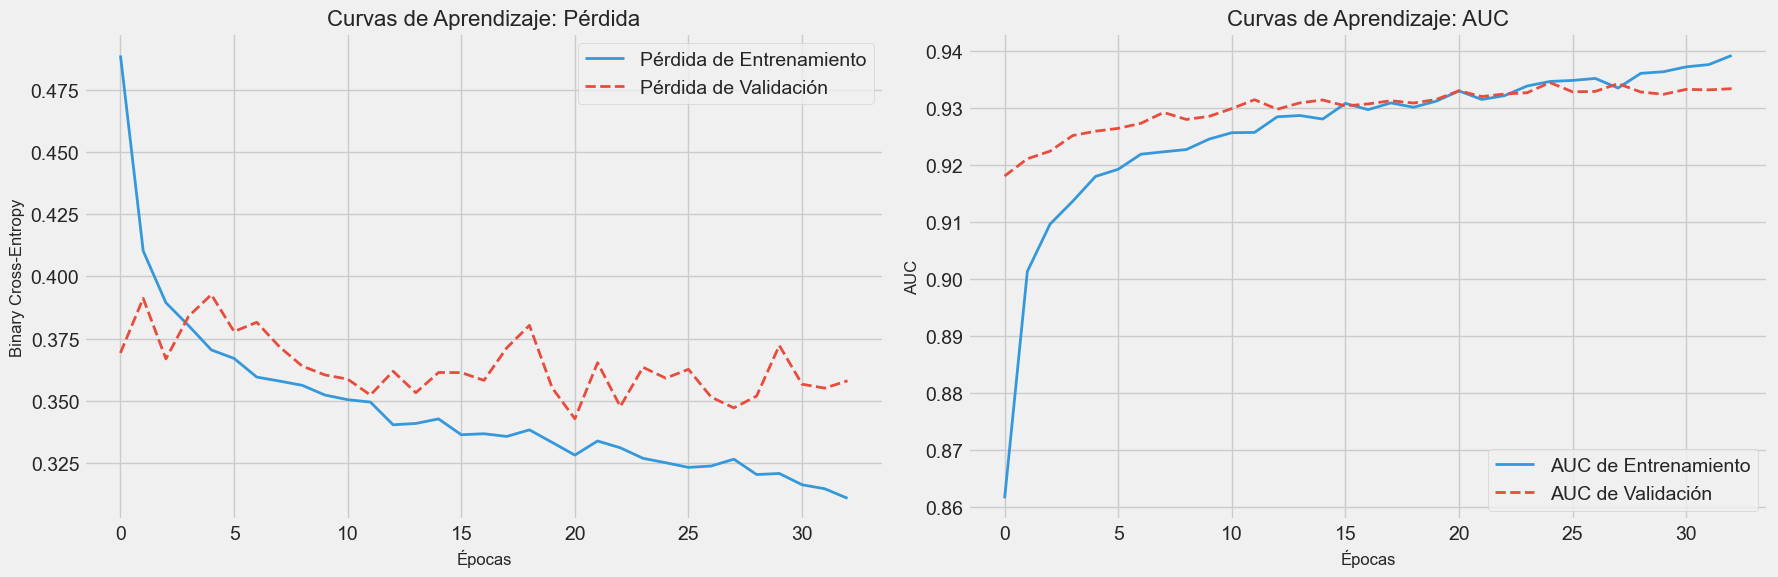

In [50]:
# -*- coding: utf-8 -*-
"""
Visualización del rendimiento durante el entrenamiento.

Graficar las curvas de aprendizaje (pérdida y métricas) para los conjuntos de
entrenamiento y validación es esencial para diagnosticar el sobreajuste y
evaluar el proceso de aprendizaje del modelo.
"""
# El objeto 'history' devuelto por model.fit() contiene un diccionario
# con los valores de pérdida y métricas de cada época.
# Lo convertimos a un DataFrame de pandas para facilitar la manipulación.
history_df = pd.DataFrame(history.history)

# Creamos una figura con dos subplots, uno al lado del otro.
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Gráfico de la Función de Pérdida (Loss) ---
# Compara cómo evolucionó el error en los datos de entrenamiento vs. validación.
axes[0].plot(history_df['loss'], label='Pérdida de Entrenamiento', color='#3498db', lw=2)
axes[0].plot(history_df['val_loss'], label='Pérdida de Validación', color='#e74c3c', lw=2, linestyle='--')
axes[0].set_title('Curvas de Aprendizaje: Pérdida', fontsize=16)
axes[0].set_xlabel('Épocas', fontsize=12)
axes[0].set_ylabel('Binary Cross-Entropy', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# --- Gráfico de la Métrica de Rendimiento (AUC) ---
# Compara el rendimiento (AUC) en los datos de entrenamiento vs. validación.
# Usamos AUC en lugar de Accuracy por ser más robusto al desbalance.
axes[1].plot(history_df['auc'], label='AUC de Entrenamiento', color='#3498db', lw=2)
axes[1].plot(history_df['val_auc'], label='AUC de Validación', color='#e74c3c', lw=2, linestyle='--')
axes[1].set_title('Curvas de Aprendizaje: AUC', fontsize=16)
axes[1].set_xlabel('Épocas', fontsize=12)
axes[1].set_ylabel('AUC', fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Ajusta el layout para evitar solapamientos y muestra la figura.
plt.tight_layout()
plt.show()

## 5. Evaluación del Rendimiento del Modelo

Ha llegado el momento de la verdad. Hasta ahora, hemos entrenado el modelo y monitoreado su rendimiento utilizando un conjunto de validación derivado de los datos de entrenamiento. Ahora, evaluaremos su capacidad de generalización final utilizando el **conjunto de prueba (`test set`)**, que el modelo no ha visto en ninguna etapa anterior.

Esta evaluación nos permitirá obtener una estimación imparcial de cómo se comportaría el modelo en un entorno de producción con datos nuevos. Nos centraremos en las métricas de clasificación clave para abordar la **Pregunta 6**.

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
ROC AUC (prob): 0.9278  |  PR-AUC (prob): 0.5979
Umbral óptimo F1: 0.804  |  Umbral óptimo F2: 0.548

--- Reporte @ 0.5 (baseline) (thr=0.500) ---
              precision    recall  f1-score   support

          No      0.983     0.820     0.894      7985
          Sí      0.397     0.893     0.549      1058

    accuracy                          0.829      9043
   macro avg      0.690     0.857     0.722      9043
weighted avg      0.914     0.829     0.854      9043



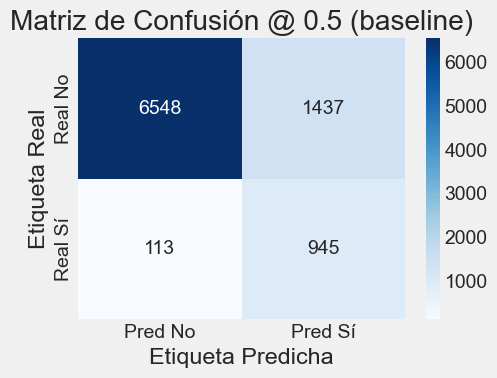


--- Reporte @ F1-óptimo (thr=0.804) ---
              precision    recall  f1-score   support

          No      0.960     0.927     0.943      7985
          Sí      0.564     0.711     0.629      1058

    accuracy                          0.902      9043
   macro avg      0.762     0.819     0.786      9043
weighted avg      0.914     0.902     0.907      9043



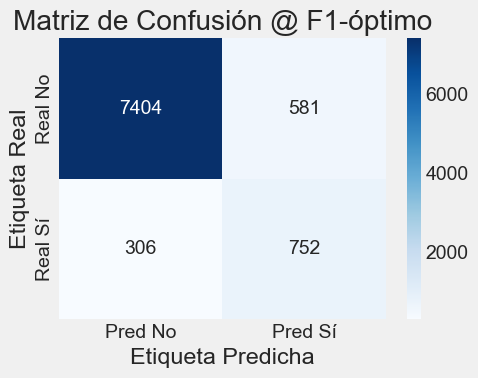

Top-10%  Conv: 0.621  Base: 0.117  Lift: 5.31x
Top-20%  Conv: 0.477  Base: 0.117  Lift: 4.08x
Top-30%  Conv: 0.361  Base: 0.117  Lift: 3.08x


In [51]:

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 4.1 Probabilidades en test (ya las usas más abajo)
y_pred_proba = model.predict(X_test_processed).ravel()

# 4.2 Métricas de ranking (umbral-agnósticas)
roc  = roc_auc_score(y_test, y_pred_proba)
pra  = average_precision_score(y_test, y_pred_proba)  # PR-AUC
print(f"ROC AUC (prob): {roc:.4f}  |  PR-AUC (prob): {pra:.4f}")

# 4.3 Umbral OPTIMO por F1 y por F2 (si priorizas recall)
prec, rec, thr = precision_recall_curve(y_test, y_pred_proba)
f1 = 2*(prec*rec)/(prec+rec+1e-12)
best_thr_f1 = thr[np.argmax(f1)]
beta = 2
f2 = (1+beta**2)*(prec*rec)/(beta**2*prec + rec + 1e-12)
best_thr_f2 = thr[np.argmax(f2)]

print(f"Umbral óptimo F1: {best_thr_f1:.3f}  |  Umbral óptimo F2: {best_thr_f2:.3f}")

# 4.4 Comparar 0.5 vs umbral óptimo (para mostrar impacto real)
def eval_with_threshold(th, name):
    y_bin = (y_pred_proba >= th).astype(int)
    print(f"\n--- Reporte @ {name} (thr={th:.3f}) ---")
    print(classification_report(y_test, y_bin, target_names=['No', 'Sí'], digits=3))
    cm = confusion_matrix(y_test, y_bin)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred No', 'Pred Sí'],
                yticklabels=['Real No', 'Real Sí'])
    plt.title(f"Matriz de Confusión @ {name}")
    plt.xlabel('Etiqueta Predicha'); plt.ylabel('Etiqueta Real')
    plt.tight_layout(); plt.show()

eval_with_threshold(0.5, '0.5 (baseline)')
eval_with_threshold(best_thr_f1, 'F1-óptimo')

# 4.5 Escenarios Top-K (capacidad de llamadas)
for K in (0.10, 0.20, 0.30):  # 10%, 20%, 30%
    cut = np.quantile(y_pred_proba, 1-K)
    y_topk = (y_pred_proba >= cut).astype(int)
    conv_rate = y_test[y_topk==1].mean()  # tasa de “sí” en llamados
    base_rate = y_test.mean()
    lift = (conv_rate / base_rate) if base_rate>0 else np.nan
    print(f"Top-{int(K*100)}%  Conv: {conv_rate:.3f}  Base: {base_rate:.3f}  Lift: {lift:.2f}x")


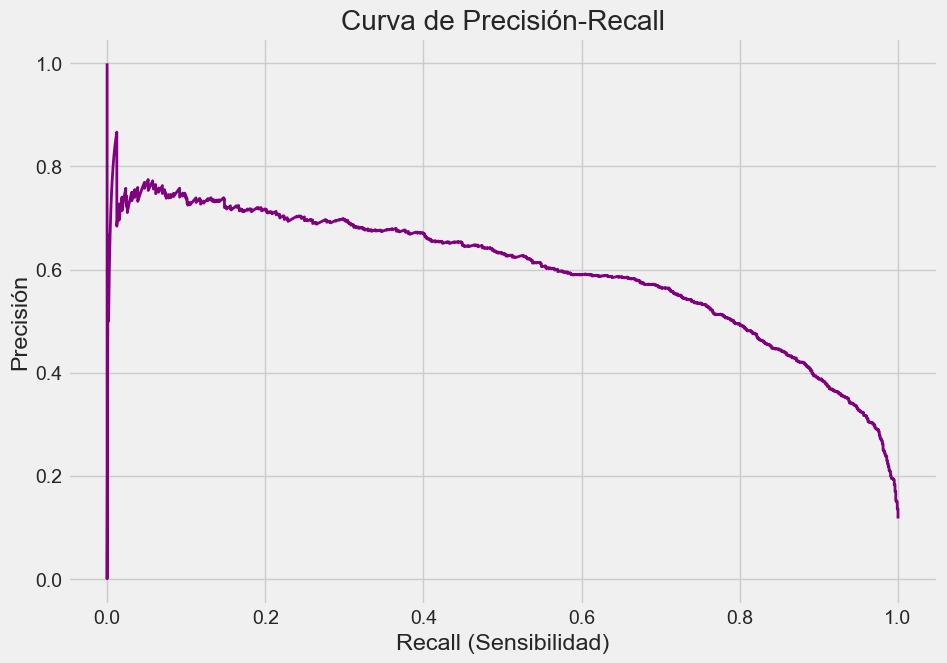

In [52]:
# -*- coding: utf-8 -*-
"""
Paso 5.2: Visualización de la Curva PR.

Esta curva muestra el rendimiento de un modelo de clasificación en todos
los umbrales de clasificación.
"""

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall')
plt.grid(True)
plt.show()

## Experimento 